Use the device name: cpu


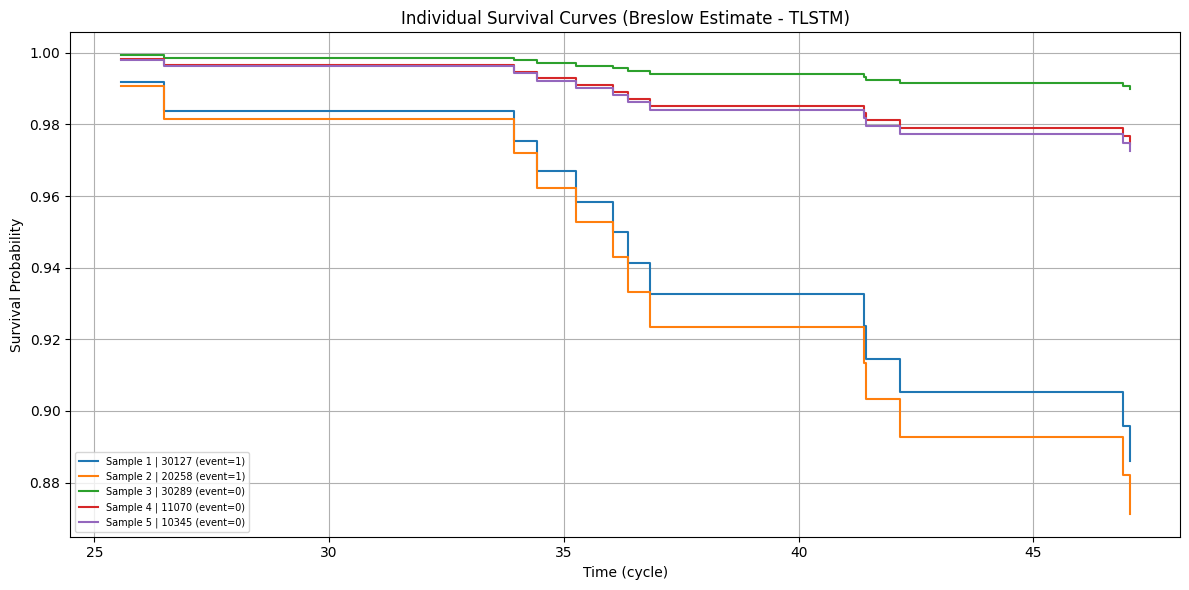

In [8]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from TLSTM import TLSTM
import matplotlib.pyplot as plt

from data_loader import get_data_loaders

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Use the device name:", device)

# Load training and validation data
train_loader, val_loader = get_data_loaders()

# Model configuration
input_dim = 5  # Number of input features
hidden_dim = 64
fc_dim = 32
output_dim = 1  # Risk score output

# Initialize TLSTM model
model = TLSTM(input_dim, hidden_dim, output_dim, fc_dim).to(device)

# Load the best saved model parameters from training
model.load_state_dict(torch.load('best_tlstm_model.pth', map_location='cpu'))


def estimate_baseline_hazard(risks, durations, events):
    """
    Estimate the baseline hazard function using the Breslow method.

    Args:
        risks (np.ndarray): Predicted risk scores (log hazard)
        durations (np.ndarray): Observed times
        events (np.ndarray): Event indicators (1 if event occurred, 0 if censored)

    Returns:
        Tuple of (event_times, baseline_hazard) where:
            - event_times: sorted unique times of observed events
            - baseline_hazard: baseline hazard at each event time
    """
    event_idx = events == 1
    event_times = np.sort(np.unique(durations[event_idx]))

    baseline_hazard = []
    for t in event_times:
        risk_set = durations >= t
        d_t = np.sum((durations == t) & event_idx)
        denom = np.sum(np.exp(risks[risk_set]))
        baseline_hazard.append(d_t / denom)

    return event_times, np.array(baseline_hazard)


def plot_survival_curves_breslow(model, loader, device, num_samples=5, min_events=2):
    """
    Plot individual survival curves using the Breslow baseline hazard estimate.

    Args:
        model: Trained TLSTM model
        loader: DataLoader (e.g. validation set)
        device: Torch device (CPU or CUDA)
        num_samples: Number of samples to plot
        min_events: Minimum number of event==1 samples to ensure some actual events are shown
    """
    model.eval()
    all_risks, all_durations, all_events = [], [], []

    # Pass through the entire dataset to collect risk predictions
    with torch.no_grad():
        for t_seq, lengths, x_seq, durations, events, pids in loader:
            x_seq = x_seq.to(device)
            t_seq = t_seq.to(device)
            durations = durations.to(device)
            events = events.to(device)

            risk_pred = model(x_seq, t_seq).squeeze(1)

            all_risks.append(risk_pred.cpu().numpy())
            all_durations.append(durations.cpu().numpy())
            all_events.append(events.cpu().numpy())

    all_risks = np.concatenate(all_risks)
    all_durations = np.concatenate(all_durations)
    all_events = np.concatenate(all_events)

    # Estimate baseline hazard and cumulative hazard
    event_times, baseline_hazard = estimate_baseline_hazard(all_risks, all_durations, all_events)
    cumulative_baseline_hazard = np.cumsum(baseline_hazard)

    # Second pass: collect individual samples with patient/company IDs
    selected_samples = []
    with torch.no_grad():
        for t_seq, lengths, x_seq, durations, events, pids in loader:
            x_seq = x_seq.to(device)
            t_seq = t_seq.to(device)
            risk_pred = model(x_seq, t_seq).squeeze(1).cpu().numpy()

            for i in range(x_seq.size(0)):
                sample = {
                    "risk": risk_pred[i],
                    "event": events[i].item(),
                    "pids": pids[i]
                }
                selected_samples.append(sample)

    # Filter samples with event==1 and others
    event_1_samples = [s for s in selected_samples if s["event"] == 1]
    other_samples = [s for s in selected_samples if s["event"] == 0]

    if len(event_1_samples) < min_events:
        print(f"Not enough event==1 samples. Found only {len(event_1_samples)}.")
        return

    # Select final set of samples to plot
    final_samples = event_1_samples[:min_events] + other_samples[:(num_samples - min_events)]

    # Plot survival curves
    plt.figure(figsize=(12, 6))
    for idx, sample in enumerate(final_samples):
        surv_probs = np.exp(-cumulative_baseline_hazard * np.exp(sample["risk"]))
        label = f"Sample {idx + 1} | {sample['pids']} (event={int(sample['event'])})"
        plt.step(event_times, surv_probs, where='post', label=label)

    plt.xlabel("Time (cycle)")
    plt.ylabel("Survival Probability")
    plt.title("Individual Survival Curves (Breslow Estimate - TLSTM)")
    plt.grid(True)
    plt.legend(fontsize=7, loc='best')
    plt.tight_layout()
    plt.show()


# Run the plotting function on the validation set
plot_survival_curves_breslow(model, val_loader, device)

In [9]:
train_loader